In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf

import keras
import keras.backend as K

from tqdm import tqdm

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

# Loading Dataset

In [3]:
from concurrent.futures import ThreadPoolExecutor

def create_dataset(file_paths, labels, batch_size=32, shuffle=True, augment=False):
    def augment_fn(image, label):
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
        do_flip = tf.random.uniform([]) > 0.5
        image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
        label = tf.cond(do_flip, lambda: tf.stack([-label[0], label[1]]), lambda: label)
    
        return image, label

    def load_image_fn(image_path: str):
        image = keras.utils.load_img(
            image_path,
            color_mode="grayscale",
            target_size=(200, 200),
            interpolation="bilinear"
        )
        
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = image[..., np.newaxis]

        return image
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        images = list(tqdm(
            executor.map(
                load_image_fn,
                file_paths
            ),
            total=len(file_paths)
        ))
    
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)

    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(lambda x, y: (x, {"Dronet_output_x": y[0], "Dronet_output_y": y[1]}))
    dataset = dataset.batch(batch_size)

    return dataset

In [4]:
@tf.function
def mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))

@tf.function
def r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
    
@tf.function
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

@tf.function
def eva(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

In [5]:
df = pd.read_csv(LABELS_PATH, sep=" ", header=None, names=["file name", "_", "datetime", "y_vel", "x_vel"])
df = df[["file name", "x_vel", "y_vel"]]
df["file name"] = df["file name"].apply(lambda name: os.path.join(IMAGES_DIRECTORY, name))

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=0)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=0)

def extract_data(df):
    return df["file name"].to_numpy(), df[["x_vel", "y_vel"]].to_numpy()

X_train, y_train = extract_data(train_df)
X_val,   y_val   = extract_data(val_df)
X_test,  y_test  = extract_data(test_df)

train_dataset      = create_dataset(X_train, y_train, batch_size=32, augment=True,  shuffle=True)
validation_dataset = create_dataset(X_val,   y_val,   batch_size=32, augment=False, shuffle=False)
test_dataset       = create_dataset(X_test,  y_test,  batch_size=32, augment=False, shuffle=False)

100%|██████████| 454/454 [00:27<00:00, 16.79it/s]


In [6]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = keras.layers.BatchNormalization()(shortcut)

    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)
    return x

def create_dronet(input_shape=(200, 200, 1), use_tl=False):
    if use_tl:
        base = keras.models.load_model(DRONET_PATH)
        base.name = f"DR_cnn_layers"
        base.trainable = False

        # for layer in base.layers:
        #     if type(layer) == keras.layers.Conv2D:
        #         layer.trainable = True
        
        inputs = base.input
        x = base.output
    else:
        inputs = keras.Input(shape=input_shape)
    
        # Initial convolution (not in the paper explicitly, but assumed before residual blocks)
        x = keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', use_bias=False)(inputs)  # (100, 100, 32)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
    
        # 3 residual blocks as per ResNet-8 (simplified)
        x = residual_block(x, 32)
        x = residual_block(x, 64, stride=2)
        x = residual_block(x, 128, stride=2)

    # Global Average Pooling and shared dropout + ReLU
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(16, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Dense(32, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    vel_x_output = keras.layers.Dense(1, activation='linear', name='Dronet_output_x')(x)
    vel_y_output = keras.layers.Dense(1, activation='linear', name='Dronet_output_y')(x)

    model = keras.models.Model(inputs=inputs, outputs=[vel_x_output, vel_y_output], name="DR-0")
    return model

In [7]:
# Instantiate and compile
model = create_dronet(use_tl=False)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss={
        'Dronet_output_x': 'mse',
        'Dronet_output_y': 'mse',
    },
    metrics={
        'Dronet_output_x': [rmse, eva, r2_score],
        'Dronet_output_y': [rmse, eva, r2_score]
    }
)

history_1 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=80,
    verbose=0
)

history_2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=9999,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(
            patience=45,
            min_delta=1e-4,
            monitor="val_loss",
            restore_best_weights=True,
            mode="min",
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=15,
            min_lr=1e-7,
            monitor="val_loss",
            mode="min"
        )
    ],
)

I0000 00:00:1744821665.248721      69 service.cc:145] XLA service 0x795ce40100c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744821665.248807      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744821670.746283      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


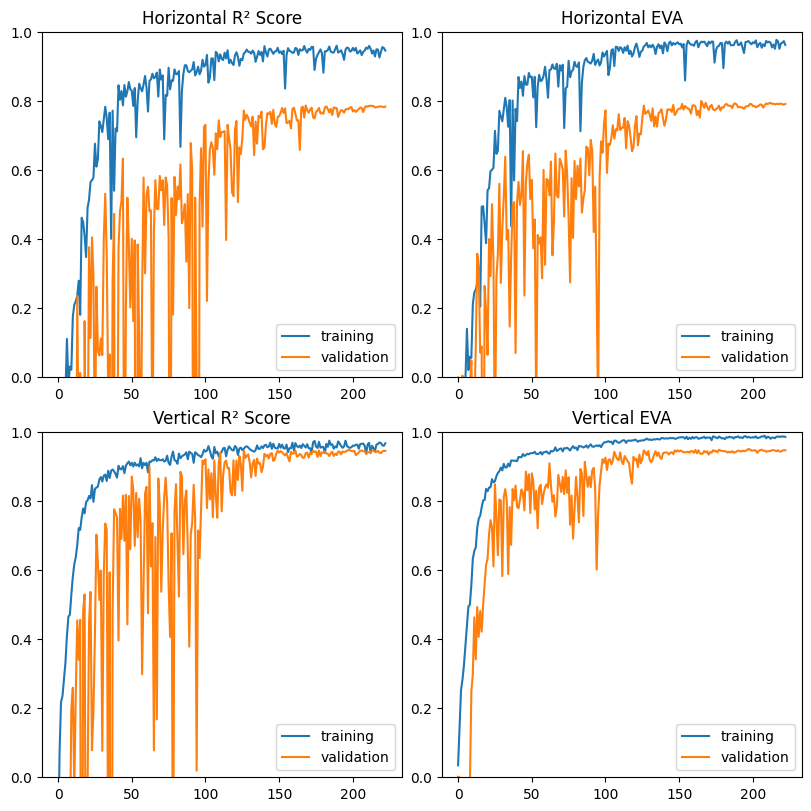

In [8]:
history_df = pd.concat([
    pd.DataFrame(history_1.history),
    pd.DataFrame(history_2.history),
]).reset_index()

history_df["learning_rate"] *= 1000

fig, ax = plt.subplots(2, 2, figsize=(8, 8), layout="constrained")

ax[0, 0].set_title("Horizontal R² Score")
ax[0, 0].plot(history_df["Dronet_output_x_r2_score"], label="training")
ax[0, 0].plot(history_df["val_Dronet_output_x_r2_score"], label="validation")
ax[0, 0].set_ylim(0, 1)
ax[0, 0].legend()

ax[0, 1].set_title("Horizontal EVA")
ax[0, 1].plot(history_df["Dronet_output_x_eva"], label="training")
ax[0, 1].plot(history_df["val_Dronet_output_x_eva"], label="validation")
ax[0, 1].set_ylim(0, 1)
ax[0, 1].legend()

ax[1, 0].set_title("Vertical R² Score")
ax[1, 0].plot(history_df["Dronet_output_y_r2_score"], label="training")
ax[1, 0].plot(history_df["val_Dronet_output_y_r2_score"], label="validation")
ax[1, 0].set_ylim(0, 1)
ax[1, 0].legend()

ax[1, 1].set_title("Vertical EVA")
ax[1, 1].plot(history_df["Dronet_output_y_eva"], label="training")
ax[1, 1].plot(history_df["val_Dronet_output_y_eva"], label="validation")
ax[1, 1].set_ylim(0, 1)
ax[1, 1].legend()


In [9]:
metrics_names = [
    "loss", "Horizontal EVA", "Horizontal R² Score", "Horizontal RMSE",
    "Vertical EVA", "Vertical R² Score", "Vertical RMSE",
]
metrics = model.evaluate(test_dataset)

for metric_name, metric in zip(metrics_names, metrics):
    print(f"{metric_name:20s}{metric:.4}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Dronet_output_x_eva: 0.8040 - Dronet_output_x_r2_score: 0.7961 - Dronet_output_x_rmse: 0.3069 - Dronet_output_y_eva: 0.9504 - Dronet_output_y_r2_score: 0.9485 - Dronet_output_y_rmse: 0.1898 - loss: 0.1464
loss                0.1687
Horizontal EVA      0.7805
Horizontal R² Score 0.7713
Horizontal RMSE     0.3229
Vertical EVA        0.944
Vertical R² Score   0.9418
Vertical RMSE       0.2043


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


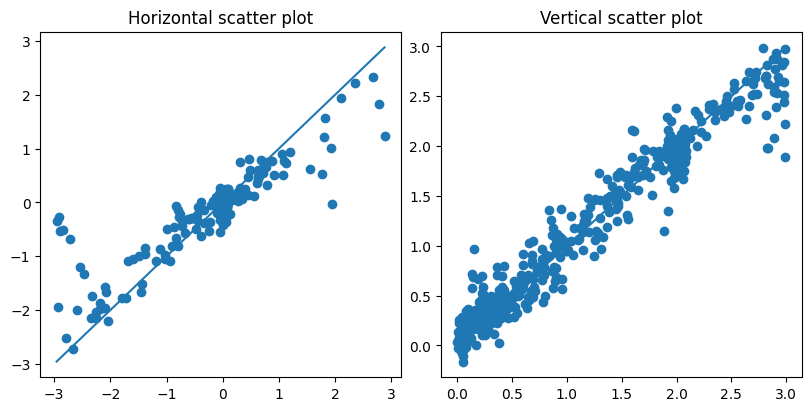

In [10]:
y_true = np.vstack([
    np.array(([y["Dronet_output_x"], y["Dronet_output_y"]])).T
    for _, y in test_dataset
])

y_pred = np.hstack(model.predict(test_dataset))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")

ax[0].set_title("Horizontal scatter plot")
ax[0].scatter(y_true[:, 0], y_pred[:, 0])
ax[0].plot([np.min(y_true[:, 0]), np.max(y_true[:, 0])], [np.min(y_true[:, 0]), np.max(y_true[:, 0])])

ax[1].set_title("Vertical scatter plot")
ax[1].scatter(y_true[:, 1], y_pred[:, 1])
ax[1].plot([np.min(y_true[:, 1]), np.max(y_true[:, 1])], [np.min(y_true[:, 1]), np.max(y_true[:, 1])])